In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import json
from scipy.stats import wilcoxon

# Processing data

In [2]:
# Loading data
rca = pd.read_csv('../../data/results/rca_ensemb.csv').dropna()
meta = pd.read_csv('../../data/psychNorms/psychNorms_metadata.csv', index_col=0)

# Adding norm_cat to rca
rca['norm_cat'] = (
    rca['norm'].apply(lambda norm: meta.loc[norm]['category'])
    .replace({'_': ' '}, regex=True)
)


with open('../../data/embed_to_dtype.json', 'r') as f:
    embed_to_type = json.load(f)
    
def embed_to_group(embed_name):
    if '&' in embed_name:
        name_1, name_2 = embed_name.split('&')
        return embed_to_type[name_1] + '&' + embed_to_type[name_2]
    else:
        return embed_to_type[embed_name]

rca['embed_group'] = rca['embed'].apply(embed_to_group)
rca

,embed,norm,train_n,fold,r2,check,norm_cat,embed_group
0,PPMI_SVD_SWOW,frequency_lund,9040,1,0.478024,pass,frequency,behavior
1,PPMI_SVD_SWOW,frequency_lund,9040,2,0.507218,pass,frequency,behavior
2,PPMI_SVD_SWOW,frequency_lund,9040,3,0.549852,pass,frequency,behavior
3,PPMI_SVD_SWOW,frequency_lund,9040,4,0.500720,pass,frequency,behavior
4,PPMI_SVD_SWOW,frequency_lund,9040,5,0.540526,pass,frequency,behavior
...,...,...,...,...,...,...,...,...
8725,fastText_CommonCrawl&PPMI_SVD_SWOW,sensory_experience_juhasz2013,3715,1,0.476002,pass,sensory,text&behavior
8726,fastText_CommonCrawl&PPMI_SVD_SWOW,sensory_experience_juhasz2013,3715,2,0.419785,pass,sensory,text&behavior
8727,fastText_CommonCrawl&PPMI_SVD_SWOW,sensory_experience_juhasz2013,3715,3,0.488512,pass,sensory,text&behavior
8728,fastText_CommonCrawl&PPMI_SVD_SWOW,sensory_experience_juhasz2013,3715,4,0.409050,pass,sensory,text&behavior


In [3]:
rca_mean = (
    rca[['embed_group', 'norm', 'fold', 'r2']]
    .groupby(['embed_group', 'norm', 'fold'], as_index=False).mean(numeric_only=True)
    .groupby(['embed_group', 'norm'], as_index=False).mean(numeric_only=True)
    .rename(columns={'r2': 'r2_mean'})
    .drop(columns='fold')
)
rca_mean

,embed_group,norm,r2_mean
0,behavior,anger_mohammad,0.418183
1,behavior,anger_stevenson,0.779470
2,behavior,angry_binder,0.623954
3,behavior,angry_zupan,0.746438
4,behavior,anticipation_mohammad,0.170381
...,...,...,...
1151,text&text,visual_lexical_rt_keuleers,0.517366
1152,text&text,visual_lexical_rt_mandera,0.459858
1153,text&text,visual_lynott,0.567903
1154,text&text,visual_troche,0.790756


In [4]:
rca_mean['norm_cat'] = (
    rca_mean['norm'].apply(lambda norm: meta.loc[norm]['category'])
)
rca_mean

,embed_group,norm,r2_mean,norm_cat
0,behavior,anger_mohammad,0.418183,emotion
1,behavior,anger_stevenson,0.779470,emotion
2,behavior,angry_binder,0.623954,emotion
3,behavior,angry_zupan,0.746438,emotion
4,behavior,anticipation_mohammad,0.170381,emotion
...,...,...,...,...
1151,text&text,visual_lexical_rt_keuleers,0.517366,visual_lexical_decision
1152,text&text,visual_lexical_rt_mandera,0.459858,visual_lexical_decision
1153,text&text,visual_lynott,0.567903,sensory
1154,text&text,visual_troche,0.790756,sensory


**Grand avgs**

In [5]:
rca_grand_avg = (
    rca_mean[['embed_group', 'norm_cat', 'r2_mean']]
    .groupby(['embed_group', 'norm_cat'], as_index=False).median(numeric_only=True)
    .rename(columns={'r2_mean': 'r2_grand_avg'})
)
rca_grand_avg

,embed_group,norm_cat,r2_grand_avg
0,behavior,age_of_acquisition,0.218570
1,behavior,animacy,0.606304
2,behavior,arousal,0.618772
3,behavior,associatability,0.208407
4,behavior,auditory_lexical_decision,0.019390
...,...,...,...
103,text&text,social/moral,0.697867
104,text&text,space/time/quantity,0.559473
105,text&text,this/that,0.568573
106,text&text,valence,0.701647


In [6]:
# Top embed_group
sorted_embeds = (
    rca_grand_avg.groupby('embed_group')['r2_grand_avg']
    .mean()
    .sort_values(ascending=True)
    .reset_index()
)
sorted_embeds

,embed_group,r2_grand_avg
0,behavior,0.398534
1,text,0.467856
2,text&behavior,0.504756
3,text&text,0.504794


**grand avg diffs**

In [7]:
# Pivoting to make it easier to compute pairwise differences 
rca_wide = ( 
    rca[['embed', 'norm', 'norm_cat', 'fold', 'r2']]
    .pivot(index=['norm', 'fold', 'norm_cat'], columns='embed', values='r2')
    .reset_index()
)
rca_wide

embed,norm,fold,norm_cat,CBOW_GoogleNews,CBOW_GoogleNews&PPMI_SVD_SWOW,CBOW_GoogleNews&fastText_CommonCrawl,PPMI_SVD_SWOW,fastText_CommonCrawl,fastText_CommonCrawl&PPMI_SVD_SWOW
0,anger_mohammad,1,emotion,0.390344,0.458841,0.412787,0.473264,0.421575,0.465897
1,anger_mohammad,2,emotion,0.347993,0.433394,0.360924,0.437635,0.352233,0.404699
2,anger_mohammad,3,emotion,0.318124,0.364982,0.336796,0.390202,0.358666,0.383394
3,anger_mohammad,4,emotion,0.340574,0.374940,0.348074,0.387522,0.357847,0.366684
4,anger_mohammad,5,emotion,0.352668,0.379915,0.377122,0.402290,0.387981,0.398382
...,...,...,...,...,...,...,...,...,...
1440,weight_binder,1,space/time/quantity,0.456006,0.563883,0.567641,0.545567,0.501701,0.602181
1441,weight_binder,2,space/time/quantity,0.564372,0.557715,0.650178,0.503094,0.606816,0.644351
1442,weight_binder,3,space/time/quantity,0.516825,0.471313,0.544514,0.314102,0.509979,0.486744
1443,weight_binder,4,space/time/quantity,0.533790,0.525982,0.619788,0.378596,0.610955,0.594715


In [8]:
text_1, text_2 = 'CBOW_GoogleNews', 'fastText_CommonCrawl' # Text
text_text = text_1 + '&' + text_2 # Text & Text 
text_behav_1 = text_1 + '&' + 'PPMI_SVD_SWOW' # Text and Behavior 1
text_behav_2 = text_2 + '&' + 'PPMI_SVD_SWOW' # Text and Behavior 2


# Text & Behavior - Text & Text 
rca_wide[f'{text_behav_1} vs {text_text}'] = rca_wide[text_behav_1] - rca_wide[text_text]
rca_wide[f'{text_behav_2} vs {text_text}'] = rca_wide[text_behav_2] - rca_wide[text_text]
tb_vs_tt = (
    rca_wide[['norm', 'fold', 'norm_cat', f'{text_behav_1} vs {text_text}', f'{text_behav_2} vs {text_text}']]
    .melt(id_vars=['norm', 'norm_cat', 'fold'])
    .rename(columns={'embed': 'comparing'})
)
tb_vs_tt

,norm,norm_cat,fold,comparing,value
0,anger_mohammad,emotion,1,CBOW_GoogleNews&PPMI_SVD_SWOW vs CBOW_GoogleNe...,0.046054
1,anger_mohammad,emotion,2,CBOW_GoogleNews&PPMI_SVD_SWOW vs CBOW_GoogleNe...,0.072470
2,anger_mohammad,emotion,3,CBOW_GoogleNews&PPMI_SVD_SWOW vs CBOW_GoogleNe...,0.028186
3,anger_mohammad,emotion,4,CBOW_GoogleNews&PPMI_SVD_SWOW vs CBOW_GoogleNe...,0.026866
4,anger_mohammad,emotion,5,CBOW_GoogleNews&PPMI_SVD_SWOW vs CBOW_GoogleNe...,0.002794
...,...,...,...,...,...
2885,weight_binder,space/time/quantity,1,fastText_CommonCrawl&PPMI_SVD_SWOW vs CBOW_Goo...,0.034540
2886,weight_binder,space/time/quantity,2,fastText_CommonCrawl&PPMI_SVD_SWOW vs CBOW_Goo...,-0.005827
2887,weight_binder,space/time/quantity,3,fastText_CommonCrawl&PPMI_SVD_SWOW vs CBOW_Goo...,-0.057771
2888,weight_binder,space/time/quantity,4,fastText_CommonCrawl&PPMI_SVD_SWOW vs CBOW_Goo...,-0.025073


In [9]:
# Computing tb_vs_tt_mean analagously to how we compute diffs for wilcoxon test below
tb_vs_tt_mean = (
    tb_vs_tt
    .groupby(['norm', 'fold'], as_index=False).mean(numeric_only=True)
    .groupby('norm', as_index=False).mean(numeric_only=True)
    .rename(columns={'value': 'r2_diff'})
    .drop(columns='fold')
)

tb_vs_tt_mean['norm_cat'] = tb_vs_tt_mean['norm'].apply(lambda norm: meta.loc[norm]['category'])
tb_vs_tt_mean

,norm,r2_diff,norm_cat
0,anger_mohammad,0.035972,emotion
1,anger_stevenson,0.047441,emotion
2,angry_binder,0.059673,emotion
3,angry_zupan,0.072669,emotion
4,anticipation_mohammad,0.017334,emotion
...,...,...,...
284,visual_lexical_rt_keuleers,-0.061469,visual_lexical_decision
285,visual_lexical_rt_mandera,-0.062446,visual_lexical_decision
286,visual_lynott,0.024201,sensory
287,visual_troche,-0.028651,sensory


In [10]:
tb_vs_tt_grand_avg = (
    tb_vs_tt_mean.groupby('norm_cat', as_index=False)
    .median(numeric_only=True)
    .rename(columns={'r2_diff': 'r2_diff_grand_avg'})
)
tb_vs_tt_grand_avg

,norm_cat,r2_diff_grand_avg
0,age_of_acquisition,-0.041819
1,animacy,-0.008076
2,arousal,0.068883
3,associatability,0.016126
4,auditory_lexical_decision,-0.018484
5,concreteness,-0.008090
6,dominance,0.079527
7,emotion,0.040242
8,familiarity,-0.037907
9,frequency,-0.036903


## Plotting 

In [11]:
# Pivot rca_grand_avg for plotting
heat_df_1 = (
    rca_grand_avg
    .pivot(index='embed_group', columns='norm_cat', values='r2_grand_avg')
    .loc[['text', 'behavior', 'text&text', 'text&behavior']]
)

# Ordering norm_cats by text&behavior performance
norm_cat_order = heat_df_1.loc['text&behavior'].sort_values(ascending=True).index
heat_df_1 = heat_df_1[norm_cat_order]
heat_df_1.index = heat_df_1.index.str.replace('&', ' & ').str.title()
heat_df_1.columns = heat_df_1.columns.str.replace('_', ' ')
heat_df_1

norm_cat,auditory lexical decision,semantic decision,number of features,naming,semantic neighborhood,iconicity/transparency,familiarity,associatability,visual lexical decision,recognition memory,...,arousal,sensory,dominance,part of speech,semantic diversity,animacy,social/moral,concreteness,valence,frequency
embed_group,,,,,,,,,,,,,,,,,,,,,
Text,0.076578,0.173717,0.180118,0.195239,0.203619,0.195218,0.298970,0.277411,0.329042,0.394782,...,0.565059,0.602651,0.525418,0.694901,0.704866,0.710796,0.656343,0.754404,0.660479,0.730974
Behavior,0.019390,0.082381,0.131251,0.095656,0.195258,0.167420,0.120309,0.208407,0.147910,0.341935,...,0.618772,0.558164,0.644671,0.448720,0.446901,0.606304,0.677820,0.640510,0.722757,0.500662
Text & Text,0.091270,0.207838,0.193075,0.231411,0.235750,0.201078,0.355254,0.313878,0.396377,0.411289,...,0.599780,0.637093,0.566376,0.724480,0.736929,0.753377,0.697867,0.784888,0.701647,0.813058
Text & Behavior,0.072786,0.158646,0.192884,0.199382,0.218237,0.218254,0.303848,0.330004,0.343152,0.409774,...,0.643168,0.650610,0.660597,0.697627,0.713732,0.731202,0.737773,0.763158,0.766702,0.768844


In [12]:
heat_df_1_winners = heat_df_1.apply(lambda col: col == col.max(), axis=0)
heat_df_1_winners

norm_cat,auditory lexical decision,semantic decision,number of features,naming,semantic neighborhood,iconicity/transparency,familiarity,associatability,visual lexical decision,recognition memory,...,arousal,sensory,dominance,part of speech,semantic diversity,animacy,social/moral,concreteness,valence,frequency
embed_group,,,,,,,,,,,,,,,,,,,,,
Text,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Behavior,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
Text & Text,True,True,True,True,True,False,True,False,True,True,...,False,False,False,True,True,True,False,True,False,True
Text & Behavior,False,False,False,False,False,True,False,True,False,False,...,True,True,True,False,False,False,True,False,True,False


In [13]:
# Pivot diffs_grand_avg for plotting
tb_vs_tt_grand_avg['comparing'] = 'text&behavior - text&text'
heat_df_2 = (
    tb_vs_tt_grand_avg
    .pivot(index='comparing', columns='norm_cat', values='r2_diff_grand_avg')
)
heat_df_2 = heat_df_2[norm_cat_order]
heat_df_2.index = heat_df_2.index.str.replace('&', ' & ').str.title()
heat_df_2.columns = heat_df_2.columns.str.replace('_', ' ')
heat_df_2

norm_cat,auditory lexical decision,semantic decision,number of features,naming,semantic neighborhood,iconicity/transparency,familiarity,associatability,visual lexical decision,recognition memory,...,arousal,sensory,dominance,part of speech,semantic diversity,animacy,social/moral,concreteness,valence,frequency
comparing,,,,,,,,,,,,,,,,,,,,,
Text & Behavior - Text & Text,-0.018484,-0.030537,-0.000191,-0.032029,-0.017513,0.008381,-0.037907,0.016126,-0.05652,-0.001515,...,0.068883,0.006752,0.079527,-0.026854,-0.04003,-0.008076,0.034867,-0.00809,0.051195,-0.036903


In [14]:
def get_diffs(norm_cat):
    # Averaging diffs across folds
    diffs = (
        tb_vs_tt.query(f'norm_cat == "{norm_cat}"')
        .groupby(['norm', 'fold'])
        .mean(numeric_only=True)['value']
    )
    
    return diffs


def wilcoxon_test(diffs):
    """Does the same as above but with wilcoxon instead of t"""
    w, p = wilcoxon(diffs)
    return {
        'median': round(diffs.median(), 2), 
        'n': len(diffs), 'w': w, 'p': p
    }

# True if the difference is significant 
heat_df_2_sigs = pd.Series(dtype=bool, index=heat_df_2.columns)
for norm_cat in heat_df_2.columns:
    diffs = get_diffs(norm_cat)
    p = wilcoxon_test(diffs)['p']
    heat_df_2_sigs[norm_cat] = p < 0.05

# Reshapes heat_df_2_sigs to match heat_df_2
heat_df_2_sigs = heat_df_2_sigs.to_frame().T
heat_df_2_sigs.index = ['Text & Behavior - Text & Text']
heat_df_2_sigs

norm_cat,auditory lexical decision,semantic decision,number of features,naming,semantic neighborhood,iconicity/transparency,familiarity,associatability,visual lexical decision,recognition memory,...,arousal,sensory,dominance,part of speech,semantic diversity,animacy,social/moral,concreteness,valence,frequency
Text & Behavior - Text & Text,True,True,False,True,False,False,True,False,True,False,...,True,True,True,True,True,True,True,False,True,True


/var/folders/st/5gbrfvhn687dxwjl5_xg21t40000gq/T/ipykernel_18313/4173034499.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap(cmap_name, 256)  # Get the original colormap


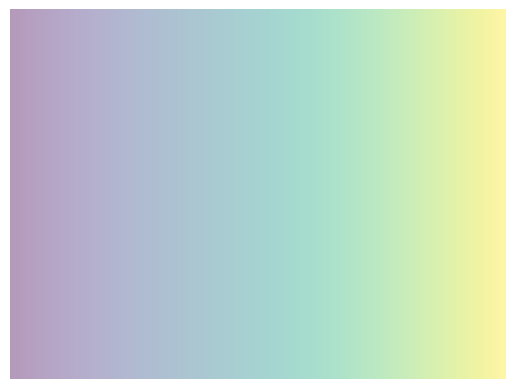

In [15]:
# Function to create a lighter version of a colormap
def lighten_cmap(cmap_name, factor=0.3):
    cmap = plt.cm.get_cmap(cmap_name, 256)  # Get the original colormap
    colors = cmap(np.linspace(0, 1, 256))

    # Blend each color with white
    white = np.array([1, 1, 1, 1])  # RGBA for white
    new_colors = (1 - factor) * colors + factor * white

    return LinearSegmentedColormap.from_list(f'light_{cmap_name}', new_colors)

# Function to visualize a colormap
def plot_colormap(cmap):
    gradient = np.linspace(0, 1, 256)
    gradient = np.vstack((gradient, gradient))

    plt.imshow(gradient, aspect='auto', cmap=cmap)
    plt.axis('off')
    plt.show()

# Usage example:
# Generate a lighter viridis colormap
lighter_viridis = lighten_cmap('viridis', factor=0.6)

# Visualize it
plot_colormap(lighter_viridis)

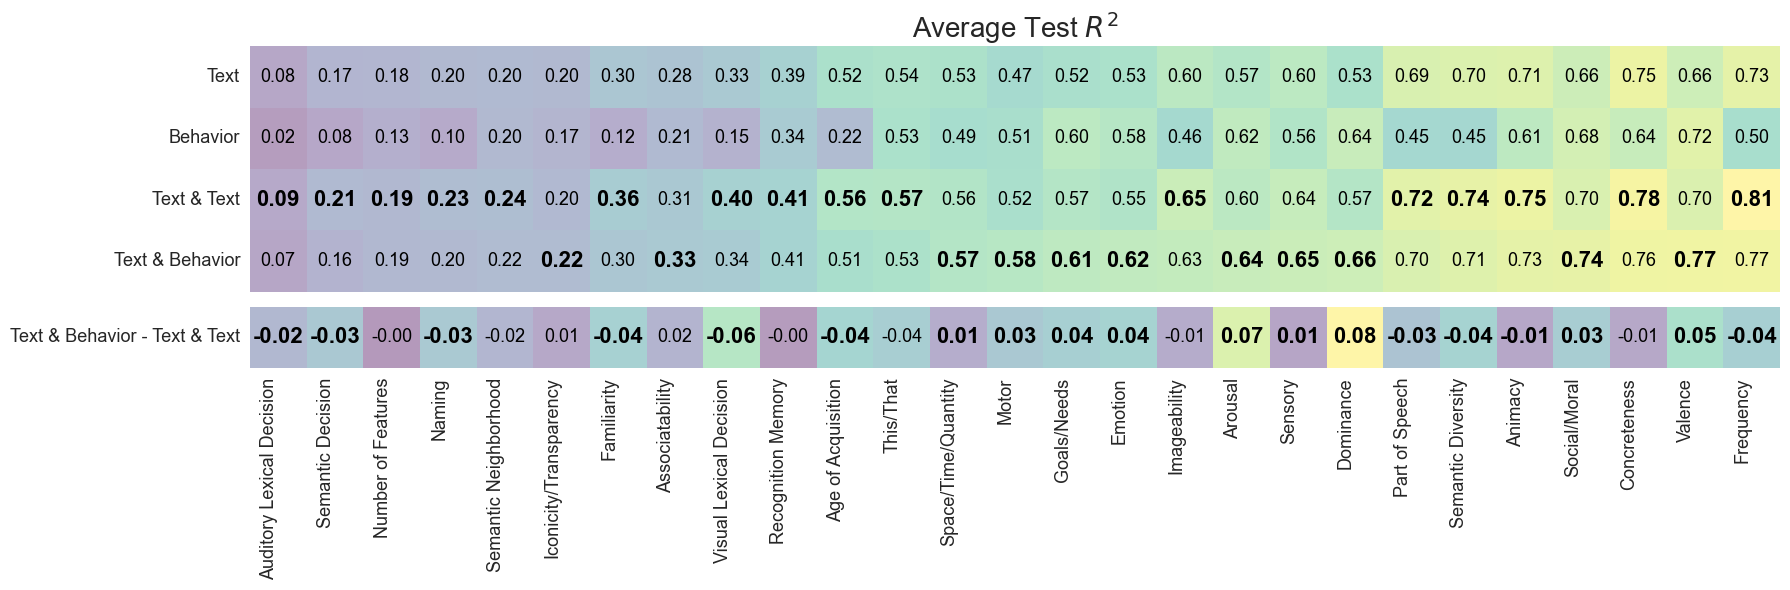

In [16]:
def annotate(heat_df, ax, mask):
    for x, norm_cat in enumerate(heat_df.columns):
        for y, embed in enumerate(heat_df.index):
            annot = heat_df.loc[embed, norm_cat]
            
            # Scientific notation
            if abs(annot) > 1e3:
                annot = f'{annot:.1e}'
            elif np.isnan(annot):
                annot = ''
            else:
                annot = f'{annot:.2f}'
            
            # Fontsize and fontweight
            fontsize, fontweight = 13, 'normal'
            if mask.loc[embed, norm_cat]:
                fontsize, fontweight = 16, 'bold'
                
            ax.text(
                x + .5, y + .5, annot, fontsize=fontsize, fontweight=fontweight,
                ha='center', va='center', color='black'
            )


heat_dfs = [heat_df_1, heat_df_2]
fig, axs = plt.subplots(2, figsize=(18, 6), height_ratios=[len(df) for df in heat_dfs])

# Plotting grand avg
vmax = heat_df_1.max().max()
sns.heatmap(
    heat_df_1, vmin=0, cmap=lighter_viridis, 
    vmax=vmax, annot=False, fmt='', cbar=False,
    ax=axs[0]
)

# Plotting text & behavior - text & text
vmax = heat_df_2.max().max()
sns.heatmap(
    heat_df_2.abs(), cmap=lighter_viridis,
    vmin=0, vmax=vmax, annot=False, fmt='', cbar=False,
    ax=axs[1]
)

for ax in axs:
    ax.set(xlabel='', ylabel='')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=13)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=13)
    
    # rotates y-tick labels to horizontal
    plt.setp(ax.get_yticklabels(), rotation=0)

# Remove x-tick labels for all but last plot
axs[0].set_xticklabels([])
x_tick_labels = heat_df_2.columns.str.title().str.replace('Of', 'of', regex=True)
axs[1].set_xticklabels(x_tick_labels, rotation=90, ha='right')

# Annotates cells
annotate(heat_df_1, axs[0], heat_df_1_winners)
annotate(heat_df_2, axs[1], heat_df_2_sigs)

# Sets axis titles
axs[0].set_title('Average Test $R^2$', fontsize=20)
  
fig.tight_layout()
plt.savefig('../../figures/rca_ensemb.png', dpi=300, bbox_inches='tight')

## Descriptive Stats

In [17]:
heat_df_2.loc['Text & Behavior - Text & Text'].sort_values().round(2)

norm_cat
visual lexical decision     -0.06
age of acquisition          -0.04
semantic diversity          -0.04
familiarity                 -0.04
frequency                   -0.04
this/that                   -0.04
naming                      -0.03
semantic decision           -0.03
part of speech              -0.03
auditory lexical decision   -0.02
semantic neighborhood       -0.02
imageability                -0.01
concreteness                -0.01
animacy                     -0.01
recognition memory          -0.00
number of features          -0.00
sensory                      0.01
iconicity/transparency       0.01
space/time/quantity          0.01
associatability              0.02
motor                        0.03
social/moral                 0.03
goals/needs                  0.04
emotion                      0.04
valence                      0.05
arousal                      0.07
dominance                    0.08
Name: Text & Behavior - Text & Text, dtype: float64

In [18]:
# checking that ensembling always improves performance
print(f"Text & Text - Text: {(heat_df_1.loc['Text & Text'] - heat_df_1.loc['Text'] < 0).any()}")
print(f"Text & Behavior - Behavior: {(heat_df_1.loc['Text & Behavior'] - heat_df_1.loc['Behavior'] < 0).any()}")

Text & Text - Text: False
Text & Behavior - Behavior: False


In [19]:
print(f"# where Text & Behavior > Text & Text: {(heat_df_2.loc['Text & Behavior - Text & Text'] > 0).sum()}")

# where Text & Behavior > Text & Text: 11
